In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = saw
band = 3b
commitnumber = 5014a19
conc = None
dv = 0.001
klin = 1e-24
molecule = h2o
ng_adju = [0]
ng_refs = [6]
nv = 1000
option_compute_btable = 0
option_compute_ktable = 0
option_wgt_flux = 1
option_wgt_k = 1
ref_pts = [(600, 250)]
tsfc = 257
vmax = 720
vmin = 620
w_diffuse = [(1.66, 1.66, 1.66, 1.55, 1.5, 1.66)]
wgt = [(0.8, 0.8, 0.8, 0.6, 0.6, 0.9)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

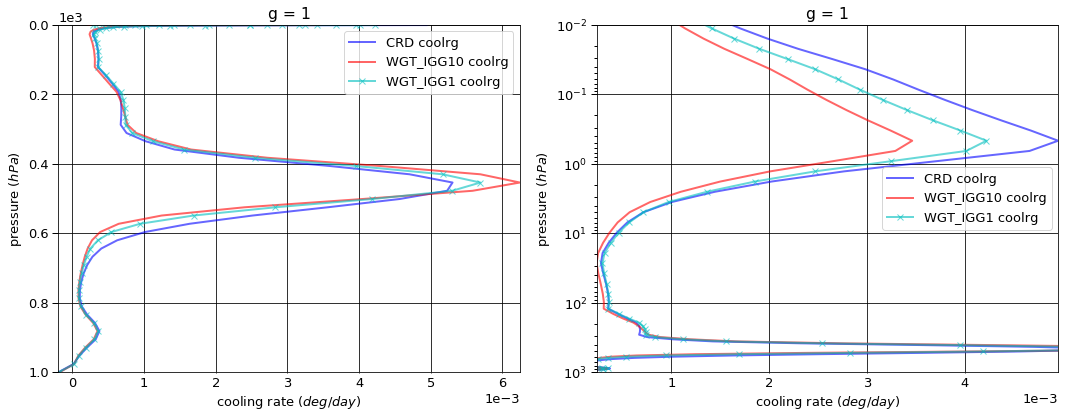

# Figure: cooling rate g-group 2

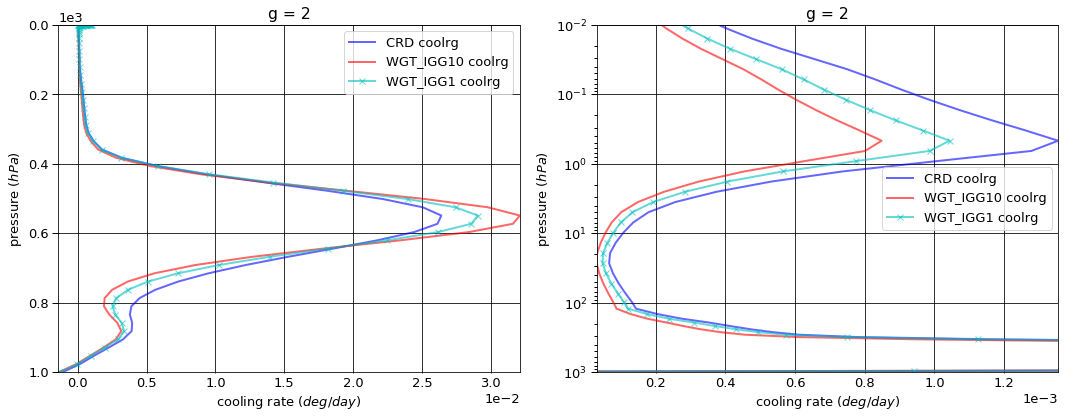

# Figure: cooling rate g-group 3

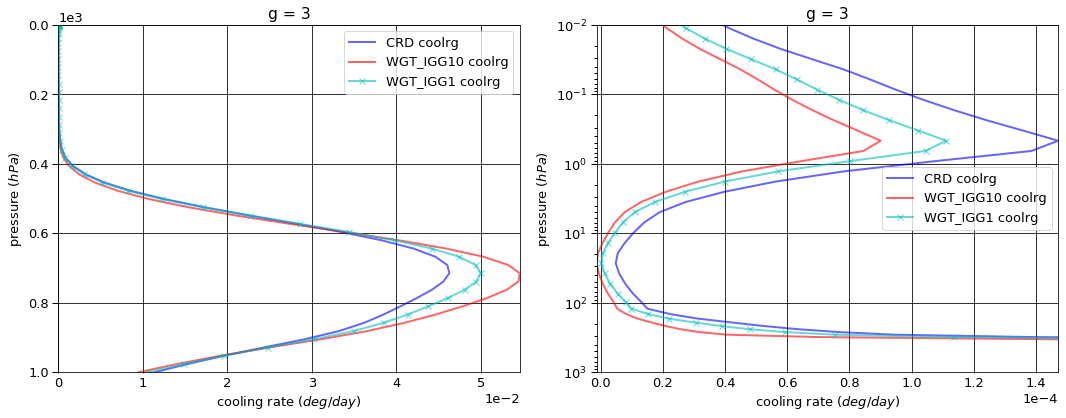

# Figure: cooling rate g-group 4

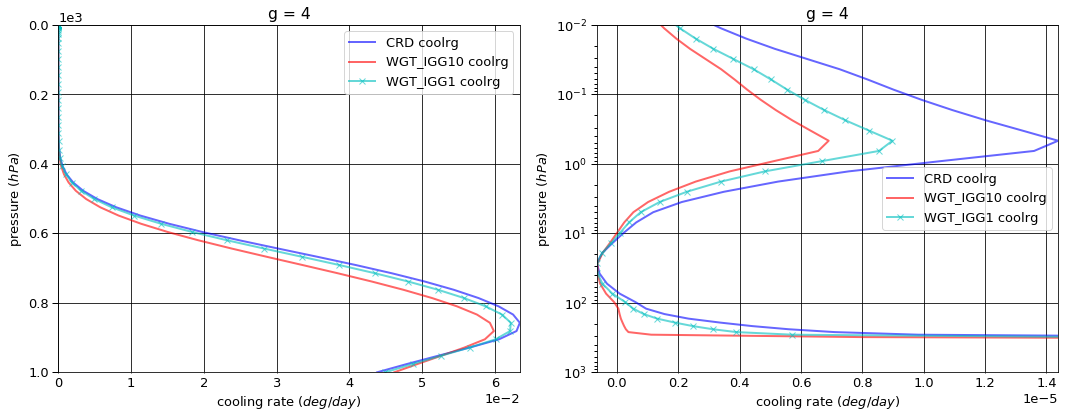

# Figure: cooling rate g-group 5

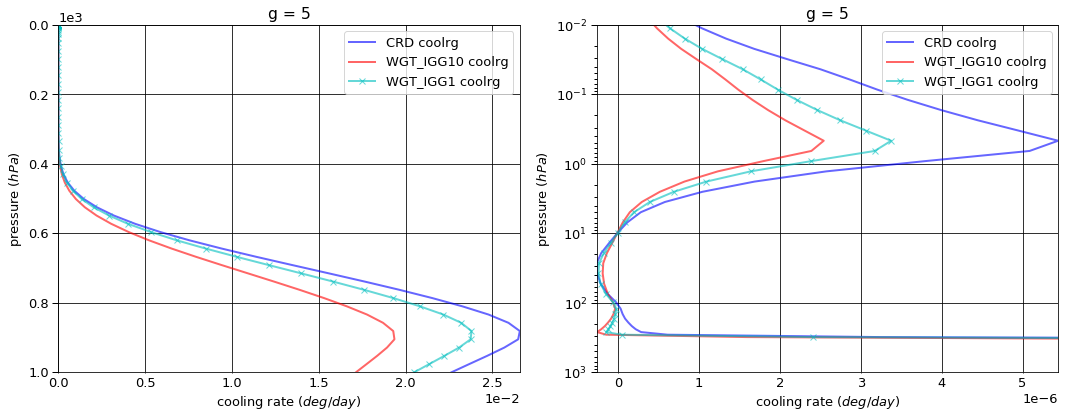

# Figure: cooling rate g-group 6

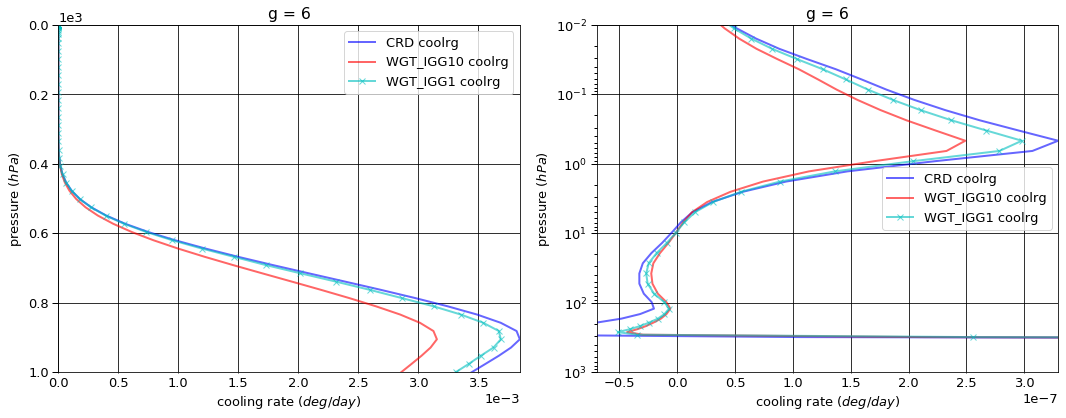

# Figure: cooling rate g-group total

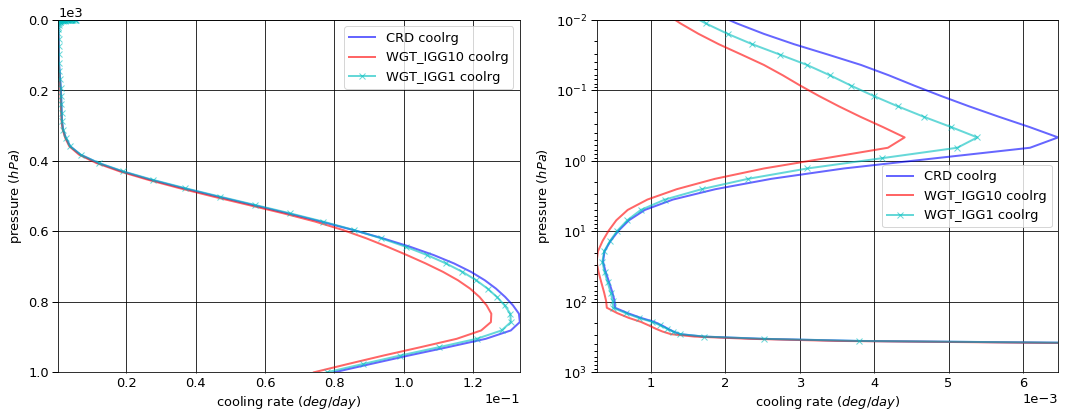

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.133193  0.000000  -0.133193
  1013.0   76     -0.206636  0.207933   0.001297
2 0.0      1      -0.826984  0.000000  -0.826984
  1013.0   76     -1.049229  1.060258   0.011029
3 0.0      1      -2.348117  0.000000  -2.348117
  1013.0   76     -2.531262  2.247168  -0.284094
4 0.0      1      -6.643708  0.000000  -6.643708
  1013.0   76     -6.734695  2.675796  -4.058898
5 0.0      1     -10.518320  0.000000 -10.518320
  1013.0   76    -10.542148  1.035268  -9.506880
6 0.0      1      -5.970299  0.000000  -5.970299
  1013.0   76     -5.973250  0.145447  -5.827802


WGT_IGG10


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.127858  0.000000  -0.127858
  1013.0   76     -0.207260  0.208428   0.001168
2 0.0      1      -0.814984  0.000000  -0.814984
  1013.0   76     -1.050155  1.061156   0.011001
3 0.0      1      -2.350811  0.000000  -2.350811
  1013.0   76     -2.533597  2.425444  -0.108153
4 0.0      1      -6.673902  0.000000  -6.673902
  1013.0   76     -6.739751  2.401635  -4.338116
5 0.0      1     -10.531242  0.000000 -10.531242
  1013.0   76    -10.547523  0.744965  -9.802558
6 0.0      1      -5.956581  0.000000  -5.956581
  1013.0   76     -5.958933  0.119098  -5.839835


WGT_IGG1


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.128437  0.000000  -0.128437
  1013.0   76     -0.207260  0.208473   0.001213
2 0.0      1      -0.816123  0.000000  -0.816123
  1013.0   76     -1.050155  1.061618   0.011463
3 0.0      1      -2.344483  0.000000  -2.344483
  1013.0   76     -2.533597  2.352592  -0.181004
4 0.0      1      -6.655110  0.000000  -6.655110
  1013.0   76     -6.739751  2.597869  -4.141882
5 0.0      1     -10.525479  0.000000 -10.525479
  1013.0   76    -10.547523  0.931064  -9.616459
6 0.0      1      -5.956082  0.000000  -5.956082
  1013.0   76     -5.958933  0.140258  -5.818675


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.005335  0.000000  0.005335
  1013.0   76    -0.000624  0.000495 -0.000129
2 0.0      1      0.012000  0.000000  0.012000
  1013.0   76    -0.000926  0.000898 -0.000028
3 0.0      1     -0.002694  0.000000 -0.002694
  1013.0   76    -0.002335  0.178276  0.175942
4 0.0      1     -0.030194  0.000000 -0.030194
  1013.0   76    -0.005057 -0.274161 -0.279217
5 0.0      1     -0.012922  0.000000 -0.012922
  1013.0   76    -0.005375 -0.290302 -0.295678
6 0.0      1      0.013718  0.000000  0.013718
  1013.0   76     0.014317 -0.026349 -0.012033


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.004756  0.000000  0.004756
  1013.0   76    -0.000624  0.000539 -0.000085
2 0.0      1      0.010861  0.000000  0.010861
  1013.0   76    -0.000926  0.001360  0.000434
3 0.0      1      0.003634  0.000000  0.003634
  1013.0   76    -0.002335  0.105424  0.103090
4 0.0      1     -0.011402  0.000000 -0.011402
  1013.0   76    -0.005057 -0.077927 -0.082983
5 0.0      1     -0.007159  0.000000 -0.007159
  1013.0   76    -0.005375 -0.104204 -0.109579
6 0.0      1      0.014217  0.000000  0.014217
  1013.0   76     0.014317 -0.005189  0.009127

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1      3.421404e-04
  1001.112500 75    -1.976291e-04
2 0.000312    1      6.362446e-05
  1001.112500 75    -1.125795e-03
3 0.000312    1      5.178828e-06
  1001.112500 75     1.137150e-02
4 0.000312    1     -4.333141e-07
  1001.112500 75     4.382250e-02
5 0.000312    1     -1.660727e-07
  1001.112500 75     2.264314e-02
6 0.000312    1     -1.068726e-08
  1001.112500 75     3.447287e-03


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1      2.211413e-04
  1001.112500 75    -1.820135e-04
2 0.000312    1      2.060557e-05
  1001.112500 75    -1.418180e-03
3 0.000312    1     -1.600122e-06
  1001.112500 75     9.505455e-03
4 0.000312    1     -2.841969e-07
  1001.112500 75     4.618330e-02
5 0.000312    1     -7.985421e-08
  1001.112500 75     1.714354e-02
6 0.000312    1     -6.052108e-09
  1001.112500 75     2.859425e-03


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1      2.919325e-04
  1001.112500 75    -1.894079e-04
2 0.000312    1      3.333141e-05
  1001.112500 75    -1.335738e-03
3 0.000312    1     -5.886156e-07
  1001.112500 75     1.062265e-02
4 0.000312    1     -3.118637e-07
  1001.112500 75     4.494724e-02
5 0.000312    1     -1.026457e-07
  1001.112500 75     2.049630e-02
6 0.000312    1     -7.409030e-09
  1001.112500 75     3.313723e-03


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -1.209990e-04
  1001.112500 75     1.561557e-05
2 0.000312    1     -4.301889e-05
  1001.112500 75    -2.923851e-04
3 0.000312    1     -6.778950e-06
  1001.112500 75    -1.866049e-03
4 0.000312    1      1.491172e-07
  1001.112500 75     2.360801e-03
5 0.000312    1      8.621853e-08
  1001.112500 75    -5.499596e-03
6 0.000312    1      4.635147e-09
  1001.112500 75    -5.878620e-04


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -5.020787e-05
  1001.112500 75     8.221210e-06
2 0.000312    1     -3.029305e-05
  1001.112500 75    -2.099435e-04
3 0.000312    1     -5.767443e-06
  1001.112500 75    -7.488540e-04
4 0.000312    1      1.214504e-07
  1001.112500 75     1.124739e-03
5 0.000312    1      6.342706e-08
  1001.112500 75    -2.146836e-03
6 0.000312    1      3.278225e-09
  1001.112500 75    -1.335638e-04

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-26.440622,0.00000,-26.440622
1013.0,76,-27.037219,7.37187,-19.665349



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-26.455378,0.000000,-26.455378
1013.0,76,-27.037219,6.960727,-20.076492



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-26.425714,0.000000,-26.425714
1013.0,76,-27.037219,7.291874,-19.745345



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-1.475653e-02,0.000000,-0.014757
1013.0,76,-1.000000e-08,-0.411143,-0.411143



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,1.490717e-02,0.000000,0.014907
1013.0,76,-1.000000e-08,-0.079996,-0.079996


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.000410
1001.112500,75,0.079961



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.000240
1001.112500,75,0.074092



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.000324
1001.112500,75,0.077855



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000171
1001.112500,75,-0.005869



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000086
1001.112500,75,-0.002106


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.00745,0.007666
2,0.03852,0.038841
3,0.09291,0.093708
4,0.24753,0.249277
5,0.38811,0.390111
6,0.22548,0.220397


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.620800e-21
2,2.554449e-22
3,4.025919e-23
4,6.345018e-24
5,1.000002e-24
6,1.306671e-25


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.620800e-21,NaN,0.00745,0.007666,0.00745,0.007666,600.0
2,2.554449e-22,0.157604,0.03852,0.038841,0.04597,0.046507,600.0
3,4.025919e-23,0.157604,0.09291,0.093708,0.13888,0.140215,600.0
4,6.345018e-24,0.157604,0.24753,0.249277,0.38641,0.389491,600.0
5,1.000002e-24,0.157604,0.38811,0.390111,0.77452,0.779603,600.0
6,1.306671e-25,0.130667,0.22548,0.220397,1.00000,1.000000,600.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
